In [1]:
# Load Modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.graph_objects as go
import ipywidgets as widgets
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gc
import plotly.express as px
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization, UtilityFunction
import zipfile

In [2]:
# unzip folder to extract data
with zipfile.ZipFile('../data/Aqueduct Water Risk.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/')

In [4]:
data_all = pd.read_csv('../data/Aqueduct Water Risk.csv', low_memory=False, encoding = 'latin-1')

In [21]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
# create state variable
data_all['name_1'] = data_all['name_1'].replace(us_state_abbrev)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (12,16,20,24,32,36,40,48) have mixed types.Specify dtype option on import or set low_memory=False.



In [22]:
water_score = data_all.loc[data_all['gid_0'] == "USA"]
# get columns with iav score and cfr score
# this is for later - does not affect prediction
water_score_other_scores = water_score[['aq30_id','iav_score', 'cfr_score']]
# keep only certain columns
water_score = water_score[['aq30_id','name_1', 'bws_score', 'bwd_score',  'sev_score', 'gtd_score',
            'rfr_score',  'drr_score',  'cep_score', 'udw_score', 'usa_score'#,'w_awr_def_tot_score' 'iav_score','cfr_score',
            ]]
water_score = water_score.sort_values('name_1')
#water_score = water_score.replace(-9999, np.nan)
# drop rows having NA on score 'cep' (needed to do this!)
water_score['cep_score'] = water_score["cep_score"].replace(-9999, np.nan)
water_score.dropna(subset = ["cep_score"], inplace=True)
# Remove Hawaii
water_score = water_score[water_score.name_1 != "HI"]
#water_score


In [23]:
#Helper Functions
#split train and test dataset based on prediction type
def select_target(data, target):
  if target == 'gtd_score':
    model_df = data[data['gtd_score'] != -9999].drop('drr_score',axis=1)
    test_set = data[data['gtd_score'] == -9999].drop('drr_score',axis=1)
    model_df = model_df.replace(-9999, np.nan)
    model_df.dropna(subset=['bws_score', 'bwd_score',  'sev_score', 'gtd_score',
            'rfr_score', 'cep_score', 'udw_score', 'usa_score'], inplace=True)
    model_df = model_df.reset_index(drop=True)
    test_set = test_set.reset_index(drop=True)

    
  elif target == 'drr_score':
    model_df = data[data['drr_score'] != -9999].drop('gtd_score',axis=1)
    test_set = data[data['drr_score'] == -9999].drop('gtd_score',axis=1)
    model_df = model_df.replace(-9999, np.nan)
    model_df.dropna(subset=['bws_score', 'bwd_score',  'sev_score', 
            'rfr_score',  'drr_score',  'cep_score', 'udw_score', 'usa_score'], inplace=True)
    model_df = model_df.reset_index(drop=True)
    test_set = test_set.reset_index(drop=True)
  return model_df, test_set

# Define the black box function to optimize hyperparameters.
def bayes_parameter_opt_lgb(data, target, init_round=20, opt_round=25, 
                            n_folds=5, random_seed=42, n_estimators=5000, output_process=False):
    model_df, test_set = select_target(data, target)
    y_train = model_df[target]
    x_train =model_df.drop([target, 'name_1', 'aq30_id'], axis=1)
    train_data = lgb.Dataset(data=x_train, label=y_train)
    def lgb_eval(num_leaves, feature_fraction,learning_rate, bagging_fraction ,max_bin,bagging_freq #,reg_lambda, reg_alpha
                 ):
        params = {'objective':'regression','num_iterations':5000, 'early_stopping_round':200, 'metric':'rmse','bagging_seed':7,'feature_fraction_seed':7}
        params["num_leaves"] = round(num_leaves)
        params['learning_rate'] = max(learning_rate, 0)
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_bin'] = round(max_bin)
        params['bagging_freq'] = round(bagging_freq)

                  
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=False ,shuffle=False,verbose_eval =200)
        #return max(cv_result['rmse-mean'])
        return (-1.0 * np.array(cv_result['rmse-mean'])).max()
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (5, 15),
                                            'learning_rate': (0.01, 1),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_bin': (50, 200),
                                        'bagging_freq' : (1, 10)},
                                        random_state=42)                                    
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round,acq='ei')
  
    #return lgbBO.res['max']['max_params']
    # return best parameters
    
    return max(lgbBO.res, key=lambda x:x['target'])['params']

# lightgbm regression model with kfold cross-validation
def model(features_train, features_test, best_params, target, n_folds=5, scaler=MinMaxScaler()):
    
    train_ids = features_train['name_1']
    test_ids = features_test['name_1']
    test_aq30_id = features_test['aq30_id']
    targets = features_train[target]
    features_train =features_train.drop([target, 'name_1', 'aq30_id'], axis=1)
    features_test = features_test.drop([target, 'name_1', 'aq30_id'], axis=1)
    #features_train, features_test = features_train.align(features_test, join='inner', axis=1)
    print('training data shape:', features_train.shape)
    print('testing data shape:', features_test.shape)
    
    feature_names = list(features_train.columns)
    features_train = np.array(features_train)
    features_test = np.array(features_test)
    feature_importance_values = np.zeros(len(feature_names))
    test_predictions = np.zeros(features_test.shape[0])
    out_of_fold = np.zeros(features_train.shape[0])


    #create kfold object to maintain same class distribution
    kfold = KFold(n_splits = n_folds, shuffle=True, random_state=42)
    #iterate through each fold
    for train_indices, valid_indices in kfold.split(features_train, targets):
        tr_features, tr_targets = features_train[train_indices], targets[train_indices]
        val_features, val_targets = features_train[valid_indices], targets[valid_indices]

        #scale the features
        tr_features = scaler.fit_transform(tr_features)
        val_featuress= scaler.transform(val_features)
       
        model = lgb.LGBMRegressor(n_estimators=5000, objective='regression',
                                  bagging_seed=7,
                                  feature_fraction_seed=7,
                                  num_leaves=int(best_params['num_leaves']),
                                  learning_rate=best_params['learning_rate'],
                                  max_bin=int(best_params['max_bin']), 
                                  bagging_fraction=best_params['bagging_fraction'],
                                  bagging_freq=int(best_params['bagging_freq']),
                                  feature_fraction=best_params['feature_fraction'],
                                  verbose=-1,
                                  random_state=42)
        #train the model
        model.fit(tr_features, tr_targets, eval_metric='mae', 
                  eval_set=[(val_features, val_targets), (tr_features, tr_targets)],
                  eval_names=['valid', 'train'],categorical_feature = 'auto', early_stopping_rounds=200, verbose=200)
       #record the best iteration
        best_iteration = model.best_iteration_
        #record the feature importance
        feature_importance_values += model.feature_importances_ / kfold.n_splits
        #make predictions
        test_predictions += model.predict(features_test, num_interation =best_iteration)/ kfold.n_splits
        #record the out of fold predictions
        out_of_fold[valid_indices] = model.predict(val_features, num_iteration=best_iteration)
        
        #clean up memory
        gc.enable()
        del model, tr_features, val_features
        gc.collect()
      
    
    
    #make feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    missing_value_prediction = pd.DataFrame({'state': test_ids, 'aq30_id' : test_aq30_id,'prediction': test_predictions})
    #overall validation score
    valid_mae = mean_absolute_error(targets, out_of_fold)
    #valid_rmse =mean_squared_error(targets, out_of_fold, squared=False)
    print('overall validation score')
    print(valid_mae)

    return  missing_value_prediction, feature_importances

#plot normalised feature importance
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (14, 8))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:20]))), 
            df['importance_normalized'].head(20), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:20]))))
    ax.set_yticklabels(df['feature'].head(20))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [24]:
def prediction(data, target, data_or_plot):
  model_df, test_set = select_target(data, target)
  opt_params = bayes_parameter_opt_lgb(water_score, picked.value, init_round=20, opt_round=25, n_folds=5, random_seed=42, n_estimators=5000)
  missing_value_prediction, fi= model(model_df, test_set, opt_params, target)
  # will give plot if apecified
  if data_or_plot == "plot":
    fi_sorted = plot_feature_importances(fi)

    df_geo = missing_value_prediction.groupby('state').agg({'prediction':'mean'})
    df_geo = df_geo.reset_index()
    fig = go.Figure()
    layout = dict(
      title_text = f'{target} prediction',
      geo_scope='usa')

    fig.add_trace(
      go.Choropleth(
          locations=df_geo.state,
          zmax=1,
          z = df_geo.prediction,
          locationmode = 'USA-states', # set of locations match entries in `locations`
          #lon = df5['Longitude'],
          #lat = df5['Latitude'],
          marker_line_color='grey',
          geo='geo',
          colorscale=px.colors.sequential.Blues))           
    fig.update_layout(layout)   
    fig.show()
  # predicted scores required to combine with other scores
  if data_or_plot == "data":
    return(missing_value_prediction)
  #US_NA_prediction = missing_value_prediction['aq30_id','prediction']
  # write code to target
  #if data_or_not == 'gtd_score':
  #  missing_value_prediction.to_csv('/content/drive/My Drive/gtd_NA_prediction.csv')
  #if target == 'drr_score':
  #  missing_value_prediction.to_csv('/content/drive/My Drive/drr_NA_prediction.csv')
 

In [ ]:
picked = widgets.Dropdown(
  options=[('Groundwater table decline', 'gtd_score'), ('Drought risk', 'drr_score')],
  value='gtd_score',
  description='Water Risk Prediction:',
)
picked


Dropdown(description='Water Risk Prediction:', options=(('Groundwater table decline', 'gtd_score'), ('Drought …

|   iter    |  target   | baggin... | baggin... | featur... | learni... |  max_bin  | num_le... |
-------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.761112 + 0.174869
|  1        | -0.7185   |  0.8749   |  9.556    |  0.6856   |  0.6027   |  73.4     |  6.56     |
[200]	cv_agg's rmse: 0.799407 + 0.185324
|  2        | -0.7625   |  0.8116   |  8.796    |  0.5809   |  0.711    |  53.09    |  14.7     |
[200]	cv_agg's rmse: 0.729765 + 0.163184
|  3        | -0.7134   |  0.9665   |  2.911    |  0.2455   |  0.1916   |  95.64    |  10.25    |
[200]	cv_agg's rmse: 0.717823 + 0.182651
|  4        | -0.6896   |  0.8864   |  3.621    |  0.5895   |  0.1481   |  93.82    |  8.664    |
[200]	cv_agg's rmse: 0.741501 + 0.146674
|  5        | -0.7203   |  0.8912   |  8.067    |  0.2597   |  0.5191   |  138.9    |  5.465    |
[200]	cv_agg's rmse: 0.804161 + 0.148454
|  6        | -0.7548   |  0.9215   |  2.535    |  0.152    |  0.9494   |  194.8    |  13.08    |
[200]	cv_agg's rmse: 0.744177 + 0.172154
|  7        | -0.7258   |  0.8609   |  1.879    |  0.6474   |  0.4458   |  68.31    |  9.952    |
[200]	cv_agg's rmse: 0.7947

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.710343 + 0.179876
|  21       | -0.6926   |  0.8722   |  3.414    |  0.758    |  0.2371   |  92.49    |  9.122    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.717267 + 0.164742
|  22       | -0.6906   |  0.8668   |  9.38     |  0.4865   |  0.223    |  184.6    |  10.72    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.720138 + 0.172833
[400]	cv_agg's rmse: 0.691703 + 0.17853
[600]	cv_agg's rmse: 0.68427 + 0.180425
[800]	cv_agg's rmse: 0.683509 + 0.180152
|  23       | -0.6818   |  1.0      |  9.609    |  0.9      |  0.01     |  183.0    |  10.07    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.701275 + 0.188058
|  24       | -0.6663   |  1.0      |  9.32     |  0.9      |  0.2764   |  183.6    |  8.928    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.735623 + 0.169444
[400]	cv_agg's rmse: 0.698005 + 0.179508
[600]	cv_agg's rmse: 0.691341 + 0.18011
[800]	cv_agg's rmse: 0.687949 + 0.18163
|  25       | -0.6878   |  1.0      |  9.48     |  0.9      |  0.01     |  183.9    |  7.806    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.789226 + 0.175559
|  26       | -0.7226   |  0.966    |  8.865    |  0.6393   |  0.9036   |  183.6    |  8.498    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.695475 + 0.171115
|  27       | -0.6889   |  0.9857   |  9.369    |  0.3358   |  0.15     |  184.3    |  9.355    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.724256 + 0.172572
|  28       | -0.7057   |  0.8517   |  9.543    |  0.6909   |  0.3769   |  183.4    |  8.822    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.759537 + 0.13702
|  29       | -0.7069   |  0.915    |  9.535    |  0.8998   |  0.8522   |  184.3    |  9.564    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.807599 + 0.16638
|  30       | -0.7372   |  0.9751   |  4.011    |  0.3688   |  0.9414   |  132.1    |  7.241    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.720295 + 0.17496
|  31       | -0.7034   |  0.902    |  9.844    |  0.6547   |  0.3177   |  183.7    |  10.07    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.710704 + 0.177608
|  32       | -0.6869   |  0.8525   |  9.772    |  0.576    |  0.2243   |  184.4    |  8.473    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.722731 + 0.176583
|  33       | -0.6855   |  0.9293   |  8.576    |  0.4745   |  0.3676   |  183.8    |  9.544    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.739913 + 0.187885
|  34       | -0.6979   |  0.9148   |  8.609    |  0.7737   |  0.3414   |  184.3    |  9.927    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.684986 + 0.184798
|  35       | -0.6812   |  0.8966   |  3.05     |  0.6271   |  0.08545  |  92.55    |  10.15    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.733789 + 0.185734
|  36       | -0.6897   |  0.9923   |  9.018    |  0.855    |  0.3406   |  183.2    |  9.478    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.687822 + 0.178123
|  37       | -0.682    |  0.997    |  8.981    |  0.8016   |  0.091    |  184.8    |  8.76     |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.680822 + 0.185687
[400]	cv_agg's rmse: 0.682064 + 0.181068
|  38       | -0.6792   |  0.8664   |  8.674    |  0.7892   |  0.05515  |  183.9    |  8.134    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.682506 + 0.173124
[400]	cv_agg's rmse: 0.684957 + 0.170887
|  39       | -0.6804   |  0.9308   |  2.884    |  0.3241   |  0.04166  |  93.47    |  9.411    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.731232 + 0.171342
[400]	cv_agg's rmse: 0.697231 + 0.17905
[600]	cv_agg's rmse: 0.687991 + 0.181687
[800]	cv_agg's rmse: 0.687715 + 0.180102
|  40       | -0.6865   |  1.0      |  9.141    |  0.9      |  0.01     |  183.9    |  8.93     |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.726662 + 0.164076
|  41       | -0.7176   |  0.8556   |  9.273    |  0.1881   |  0.2021   |  184.2    |  9.122    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.72868 + 0.162676
|  42       | -0.7128   |  0.9938   |  9.607    |  0.1986   |  0.2081   |  184.4    |  9.779    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.73767 + 0.14261
[400]	cv_agg's rmse: 0.700348 + 0.159876
[600]	cv_agg's rmse: 0.690967 + 0.167487
[800]	cv_agg's rmse: 0.689536 + 0.169059
|  43       | -0.6885   |  0.8197   |  3.226    |  0.289    |  0.01207  |  93.26    |  9.927    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.903345 + 0.183213
|  44       | -0.7723   |  0.8131   |  3.863    |  0.4464   |  0.9987   |  59.65    |  11.96    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.7716 + 0.145529
|  45       | -0.7364   |  0.9068   |  5.256    |  0.1168   |  0.5827   |  144.4    |  11.32    |
training data shape: (1080, 7)
testing data shape: (2237, 7)
Training until validation scores don't improve for 200 rounds.
[200]	train's l1: 0.226989	train's l2: 0.148616	valid's l1: 1.00874	valid's l2: 1.37751
Early stopping, best iteration is:
[1]	train's l1: 0.561655	train's l2: 0.608707	valid's l1: 0.667029	valid's l2: 0.827827
Training until validation scores don't improve for 200 rounds.
[200]	train's l1: 0.216554	train's l2: 0.141209	valid's l1: 0.811939	valid's l2: 1.17254
Early stopping, best iteration is:
[1]	train's l1: 0.565744	train's l2: 0.61024	valid's l1: 0.648249	valid's l2: 0.749859
Training until validation scores don't improve for 200 rounds.
[200]	train's l1: 0.226315	train's l2: 0.14318	valid's l1: 0.84523	valid's l2: 1.11917
Early stopping, best iteration is:
[1]	train's l1: 0.572805	train's l2: 0.618412	valid's l1: 0.713905	va

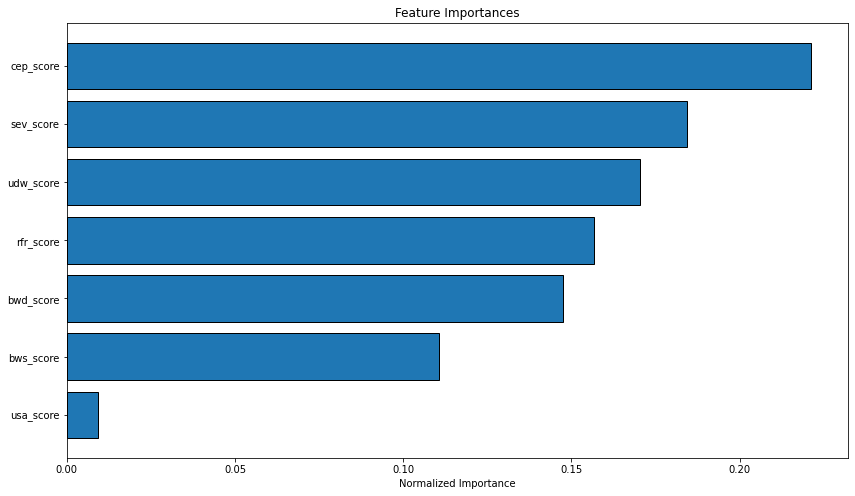

In [25]:
prediction(water_score, picked.value, 'plot')

In [26]:
# get data for scores for rfr_score and drr_score
drr_score_predict = prediction(water_score, 'drr_score', 'data')
gtd_score_predict = prediction(water_score, 'gtd_score', 'data')

|   iter    |  target   | baggin... | baggin... | featur... | learni... |  max_bin  | num_le... |
-------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.761112 + 0.174869
|  1        | -0.7185   |  0.8749   |  9.556    |  0.6856   |  0.6027   |  73.4     |  6.56     |
[200]	cv_agg's rmse: 0.799407 + 0.185324
|  2        | -0.7625   |  0.8116   |  8.796    |  0.5809   |  0.711    |  53.09    |  14.7     |
[200]	cv_agg's rmse: 0.729765 + 0.163184
|  3        | -0.7134   |  0.9665   |  2.911    |  0.2455   |  0.1916   |  95.64    |  10.25    |
[200]	cv_agg's rmse: 0.717823 + 0.182651
|  4        | -0.6896   |  0.8864   |  3.621    |  0.5895   |  0.1481   |  93.82    |  8.664    |
[200]	cv_agg's rmse: 0.741501 + 0.146674
|  5        | -0.7203   |  0.8912   |  8.067    |  0.2597   |  0.5191   |  138.9    |  5.465    |
[200]	cv_agg's rmse: 0.804161 + 0.148454
|  6        | -0.7548   |  0.9215   |  2.535    |  0.152    |  0.9494   |  194.8    |  13.08    |
[200]	cv_agg's rmse: 0.744177 + 0.172154
|  7        | -0.7258   |  0.8609   |  1.879    |  0.6474   |  0.4458   |  68.31    |  9.952    |
[200]	cv_agg's rmse: 0.7947

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.710343 + 0.179876
|  21       | -0.6926   |  0.8722   |  3.414    |  0.758    |  0.2371   |  92.49    |  9.122    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.717267 + 0.164742
|  22       | -0.6906   |  0.8668   |  9.38     |  0.4865   |  0.223    |  184.6    |  10.72    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.720138 + 0.172833
[400]	cv_agg's rmse: 0.691703 + 0.17853
[600]	cv_agg's rmse: 0.68427 + 0.180425
[800]	cv_agg's rmse: 0.683509 + 0.180152
|  23       | -0.6818   |  1.0      |  9.609    |  0.9      |  0.01     |  183.0    |  10.07    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.701275 + 0.188058
|  24       | -0.6663   |  1.0      |  9.32     |  0.9      |  0.2764   |  183.6    |  8.928    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.735623 + 0.169444
[400]	cv_agg's rmse: 0.698005 + 0.179508
[600]	cv_agg's rmse: 0.691341 + 0.18011
[800]	cv_agg's rmse: 0.687949 + 0.18163
|  25       | -0.6878   |  1.0      |  9.48     |  0.9      |  0.01     |  183.9    |  7.806    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.789226 + 0.175559
|  26       | -0.7226   |  0.966    |  8.865    |  0.6393   |  0.9036   |  183.6    |  8.498    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.695475 + 0.171115
|  27       | -0.6889   |  0.9857   |  9.369    |  0.3358   |  0.15     |  184.3    |  9.355    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.724256 + 0.172572
|  28       | -0.7057   |  0.8517   |  9.543    |  0.6909   |  0.3769   |  183.4    |  8.822    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.759537 + 0.13702
|  29       | -0.7069   |  0.915    |  9.535    |  0.8998   |  0.8522   |  184.3    |  9.564    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.807599 + 0.16638
|  30       | -0.7372   |  0.9751   |  4.011    |  0.3688   |  0.9414   |  132.1    |  7.241    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.720295 + 0.17496
|  31       | -0.7034   |  0.902    |  9.844    |  0.6547   |  0.3177   |  183.7    |  10.07    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.710704 + 0.177608
|  32       | -0.6869   |  0.8525   |  9.772    |  0.576    |  0.2243   |  184.4    |  8.473    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.722731 + 0.176583
|  33       | -0.6855   |  0.9293   |  8.576    |  0.4745   |  0.3676   |  183.8    |  9.544    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.739913 + 0.187885
|  34       | -0.6979   |  0.9148   |  8.609    |  0.7737   |  0.3414   |  184.3    |  9.927    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.684986 + 0.184798
|  35       | -0.6812   |  0.8966   |  3.05     |  0.6271   |  0.08545  |  92.55    |  10.15    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.733789 + 0.185734
|  36       | -0.6897   |  0.9923   |  9.018    |  0.855    |  0.3406   |  183.2    |  9.478    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.687822 + 0.178123
|  37       | -0.682    |  0.997    |  8.981    |  0.8016   |  0.091    |  184.8    |  8.76     |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.680822 + 0.185687
[400]	cv_agg's rmse: 0.682064 + 0.181068
|  38       | -0.6792   |  0.8664   |  8.674    |  0.7892   |  0.05515  |  183.9    |  8.134    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.682506 + 0.173124
[400]	cv_agg's rmse: 0.684957 + 0.170887
|  39       | -0.6804   |  0.9308   |  2.884    |  0.3241   |  0.04166  |  93.47    |  9.411    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.731232 + 0.171342
[400]	cv_agg's rmse: 0.697231 + 0.17905
[600]	cv_agg's rmse: 0.687991 + 0.181687
[800]	cv_agg's rmse: 0.687715 + 0.180102
|  40       | -0.6865   |  1.0      |  9.141    |  0.9      |  0.01     |  183.9    |  8.93     |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.726662 + 0.164076
|  41       | -0.7176   |  0.8556   |  9.273    |  0.1881   |  0.2021   |  184.2    |  9.122    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.72868 + 0.162676
|  42       | -0.7128   |  0.9938   |  9.607    |  0.1986   |  0.2081   |  184.4    |  9.779    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.73767 + 0.14261
[400]	cv_agg's rmse: 0.700348 + 0.159876
[600]	cv_agg's rmse: 0.690967 + 0.167487
[800]	cv_agg's rmse: 0.689536 + 0.169059
|  43       | -0.6885   |  0.8197   |  3.226    |  0.289    |  0.01207  |  93.26    |  9.927    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.903345 + 0.183213
|  44       | -0.7723   |  0.8131   |  3.863    |  0.4464   |  0.9987   |  59.65    |  11.96    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.7716 + 0.145529
|  45       | -0.7364   |  0.9068   |  5.256    |  0.1168   |  0.5827   |  144.4    |  11.32    |
training data shape: (3186, 7)
testing data shape: (131, 7)
Training until validation scores don't improve for 200 rounds.
[200]	train's l1: 0.0877876	train's l2: 0.0162455	valid's l1: 0.488021	valid's l2: 0.384868
Early stopping, best iteration is:
[14]	train's l1: 0.224218	train's l2: 0.0832899	valid's l1: 0.46126	valid's l2: 0.369587
Training until validation scores don't improve for 200 rounds.
[200]	train's l1: 0.0839313	train's l2: 0.0152731	valid's l1: 0.449439	valid's l2: 0.35867
Early stopping, best iteration is:
[6]	train's l1: 0.263411	train's l2: 0.108954	valid's l1: 0.428214	valid's l2: 0.317566
Training until validation scores don't improve for 200 rounds.
[200]	train's l1: 0.084882	train's l2: 0.0151322	valid's l1: 0.462723	valid's l2: 0.359037
Early stopping, best iteration is:
[13]	train's l1: 0.22527	train's l2: 0.0817938	valid's l1:

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.761112 + 0.174869
|  1        | -0.7185   |  0.8749   |  9.556    |  0.6856   |  0.6027   |  73.4     |  6.56     |
[200]	cv_agg's rmse: 0.799407 + 0.185324
|  2        | -0.7625   |  0.8116   |  8.796    |  0.5809   |  0.711    |  53.09    |  14.7     |
[200]	cv_agg's rmse: 0.729765 + 0.163184
|  3        | -0.7134   |  0.9665   |  2.911    |  0.2455   |  0.1916   |  95.64    |  10.25    |
[200]	cv_agg's rmse: 0.717823 + 0.182651
|  4        | -0.6896   |  0.8864   |  3.621    |  0.5895   |  0.1481   |  93.82    |  8.664    |
[200]	cv_agg's rmse: 0.741501 + 0.146674
|  5        | -0.7203   |  0.8912   |  8.067    |  0.2597   |  0.5191   |  138.9    |  5.465    |
[200]	cv_agg's rmse: 0.804161 + 0.148454
|  6        | -0.7548   |  0.9215   |  2.535    |  0.152    |  0.9494   |  194.8    |  13.08    |
[200]	cv_agg's rmse: 0.744177 + 0.172154
|  7        | -0.7258   |  0.8609   |  1.879    |  0.6474   |  0.4458   |  68.31    |  9.952    |
[200]	cv_agg's rmse: 0.7947

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.710343 + 0.179876
|  21       | -0.6926   |  0.8722   |  3.414    |  0.758    |  0.2371   |  92.49    |  9.122    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.717267 + 0.164742
|  22       | -0.6906   |  0.8668   |  9.38     |  0.4865   |  0.223    |  184.6    |  10.72    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.720138 + 0.172833
[400]	cv_agg's rmse: 0.691703 + 0.17853
[600]	cv_agg's rmse: 0.68427 + 0.180425
[800]	cv_agg's rmse: 0.683509 + 0.180152
|  23       | -0.6818   |  1.0      |  9.609    |  0.9      |  0.01     |  183.0    |  10.07    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.701275 + 0.188058
|  24       | -0.6663   |  1.0      |  9.32     |  0.9      |  0.2764   |  183.6    |  8.928    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.735623 + 0.169444
[400]	cv_agg's rmse: 0.698005 + 0.179508
[600]	cv_agg's rmse: 0.691341 + 0.18011
[800]	cv_agg's rmse: 0.687949 + 0.18163
|  25       | -0.6878   |  1.0      |  9.48     |  0.9      |  0.01     |  183.9    |  7.806    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.789226 + 0.175559
|  26       | -0.7226   |  0.966    |  8.865    |  0.6393   |  0.9036   |  183.6    |  8.498    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.695475 + 0.171115
|  27       | -0.6889   |  0.9857   |  9.369    |  0.3358   |  0.15     |  184.3    |  9.355    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.724256 + 0.172572
|  28       | -0.7057   |  0.8517   |  9.543    |  0.6909   |  0.3769   |  183.4    |  8.822    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.759537 + 0.13702
|  29       | -0.7069   |  0.915    |  9.535    |  0.8998   |  0.8522   |  184.3    |  9.564    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.807599 + 0.16638
|  30       | -0.7372   |  0.9751   |  4.011    |  0.3688   |  0.9414   |  132.1    |  7.241    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.720295 + 0.17496
|  31       | -0.7034   |  0.902    |  9.844    |  0.6547   |  0.3177   |  183.7    |  10.07    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.710704 + 0.177608
|  32       | -0.6869   |  0.8525   |  9.772    |  0.576    |  0.2243   |  184.4    |  8.473    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.722731 + 0.176583
|  33       | -0.6855   |  0.9293   |  8.576    |  0.4745   |  0.3676   |  183.8    |  9.544    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.739913 + 0.187885
|  34       | -0.6979   |  0.9148   |  8.609    |  0.7737   |  0.3414   |  184.3    |  9.927    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.684986 + 0.184798
|  35       | -0.6812   |  0.8966   |  3.05     |  0.6271   |  0.08545  |  92.55    |  10.15    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.733789 + 0.185734
|  36       | -0.6897   |  0.9923   |  9.018    |  0.855    |  0.3406   |  183.2    |  9.478    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.687822 + 0.178123
|  37       | -0.682    |  0.997    |  8.981    |  0.8016   |  0.091    |  184.8    |  8.76     |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.680822 + 0.185687
[400]	cv_agg's rmse: 0.682064 + 0.181068
|  38       | -0.6792   |  0.8664   |  8.674    |  0.7892   |  0.05515  |  183.9    |  8.134    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.682506 + 0.173124
[400]	cv_agg's rmse: 0.684957 + 0.170887
|  39       | -0.6804   |  0.9308   |  2.884    |  0.3241   |  0.04166  |  93.47    |  9.411    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.731232 + 0.171342
[400]	cv_agg's rmse: 0.697231 + 0.17905
[600]	cv_agg's rmse: 0.687991 + 0.181687
[800]	cv_agg's rmse: 0.687715 + 0.180102
|  40       | -0.6865   |  1.0      |  9.141    |  0.9      |  0.01     |  183.9    |  8.93     |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.726662 + 0.164076
|  41       | -0.7176   |  0.8556   |  9.273    |  0.1881   |  0.2021   |  184.2    |  9.122    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.72868 + 0.162676
|  42       | -0.7128   |  0.9938   |  9.607    |  0.1986   |  0.2081   |  184.4    |  9.779    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.73767 + 0.14261
[400]	cv_agg's rmse: 0.700348 + 0.159876
[600]	cv_agg's rmse: 0.690967 + 0.167487
[800]	cv_agg's rmse: 0.689536 + 0.169059
|  43       | -0.6885   |  0.8197   |  3.226    |  0.289    |  0.01207  |  93.26    |  9.927    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.903345 + 0.183213
|  44       | -0.7723   |  0.8131   |  3.863    |  0.4464   |  0.9987   |  59.65    |  11.96    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[200]	cv_agg's rmse: 0.7716 + 0.145529
|  45       | -0.7364   |  0.9068   |  5.256    |  0.1168   |  0.5827   |  144.4    |  11.32    |
training data shape: (1080, 7)
testing data shape: (2237, 7)
Training until validation scores don't improve for 200 rounds.
[200]	train's l1: 0.226989	train's l2: 0.148616	valid's l1: 1.00874	valid's l2: 1.37751
Early stopping, best iteration is:
[1]	train's l1: 0.561655	train's l2: 0.608707	valid's l1: 0.667029	valid's l2: 0.827827
Training until validation scores don't improve for 200 rounds.
[200]	train's l1: 0.216554	train's l2: 0.141209	valid's l1: 0.811939	valid's l2: 1.17254
Early stopping, best iteration is:
[1]	train's l1: 0.565744	train's l2: 0.61024	valid's l1: 0.648249	valid's l2: 0.749859
Training until validation scores don't improve for 200 rounds.
[200]	train's l1: 0.226315	train's l2: 0.14318	valid's l1: 0.84523	valid's l2: 1.11917
Early stopping, best iteration is:
[1]	train's l1: 0.572805	train's l2: 0.618412	valid's l1: 0.713905	va

In [27]:
drr_score_predict
gtd_score_predict

,state,aq30_id,prediction
0,AK,59662,1.910036
1,AK,59661,1.910036
2,AK,59652,1.541879
3,AK,59651,1.541879
4,AK,59648,1.961671
...,...,...,...
2232,WY,54995,1.965064
2233,WY,54997,1.657766
2234,WY,54998,1.778101
2235,WY,55000,1.744958


In [28]:
# merge all scores together
merged = water_score.merge(drr_score_predict, on=['aq30_id'], how='left')
merged2 = merged.merge(water_score_other_scores, on=['aq30_id'], how='left')
merged_final = merged2.merge(gtd_score_predict, on=['aq30_id'], how='left')


# take maximum value to replace NA
merged_final['gtd_score'] = np.max(merged_final[['gtd_score', 'prediction_y']], axis=1)
merged_final['drr_score'] = np.max(merged_final[['drr_score', 'prediction_x']], axis=1)
# remove columns
merged_final = merged_final.drop(columns=['state_x', 'state_y','prediction_x', 'prediction_y'], axis=1)

# get long names of states again
us_state_elon = {
    'AL':'Alabama',
    'AK':'Alaska',
    'AZ':'Arizona',
    'AR':'Arkansas',
    'CA':'California',
    'CO':'Colorado',
    'CT':'Connecticut',
    'DE':'Delaware',
    'DC':'District of Columbia',
    'FL': 'Florida',
    'GA':'Georgia',
    'ID':'Idaho',
    'IL':'Illinois',
    'IN':'Indiana',
    'IA':'Iowa',
    'KS':'Kansas',
    'KY':'Kentucky',
    'LA':'Louisiana',
    'ME':'Maine',
    'MD':'Maryland',
    'MA':'Massachusetts',
    'MI':'Michigan',
    'MN':'Minnesota',
    'MS':'Mississippi',
    'MO':'Missouri',
    'MT':'Montana',
    'NE':'Nebraska',
    'NV':'Nevada',
    'NH':'New Hampshire',
    'NJ':'New Jersey',
    'NM':'New Mexico',
    'NY':'New York',
    'NC':'North Carolina',
    'ND':'North Dakota',
    'OH': 'Ohio',
    'OK':'Oklahoma',
    'OR':'Oregon',
    'PA':'Pennsylvania',
    'RI':'Rhode Island',
    'SC':'South Carolina',
    'SD':'South Dakota',
    'TN':'Tennessee',
    'TX':'Texas',
    'UT':'Utah',
    'VT':'Vermont',
    'VA':'Virginia',
    'WA':'Washington',
    'WV':'West Virginia',
    'WI':'Wisconsin',
    'WY':'Wyoming'
}

# get loong names of state back
merged_final['name_1'] = merged_final['name_1'].replace(us_state_elon)
merged_final = merged_final.sort_values('name_1')

# now aggregate scores by mean
final = merged_final[['name_1', 'bws_score', 'bwd_score',  'sev_score', 'gtd_score',
            'rfr_score',  'drr_score',  'cep_score', 'udw_score', 'usa_score', 'iav_score', 'cfr_score']].groupby('name_1').agg('mean')
final = final.reset_index()
# rename to state
final.rename(columns = {'name_1':'State'}, inplace = True)
final

# write to csv
final.to_csv('../data/water_scores.csv', index = False)